# Assignment 9: Denoising Diffusion Models

## Submitted By: Aarathi Vijayachandran (244267)

### Assignment question is available here: https://ovgu-ailab.github.io/lgm2024/assignment9.html

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Lambda

# Abbreviating tensorflow_probability and keras for easier use
tfpd = tfp.distributions
tfk = tf.keras
tfkl = tfk.layers


DATASET

In [2]:
# Set batch size for training
batch_size = 512

# Loading and preprocessing MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
print(f"Shape of training images: {train_images.shape}")
train_images = np.pad(train_images[..., None], ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant').astype(np.float32) / 255.
test_images = np.pad(test_images[..., None], ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant').astype(np.float32) / 255.

# Creating tensorflow datasets for training and testing
train_data = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices(test_images).batch(32)


11490434/11490434 [==============================] - 0s 0us/step
Shape of training images: (60000, 28, 28)


In [3]:
train_images.shape

(60000, 32, 32, 1)

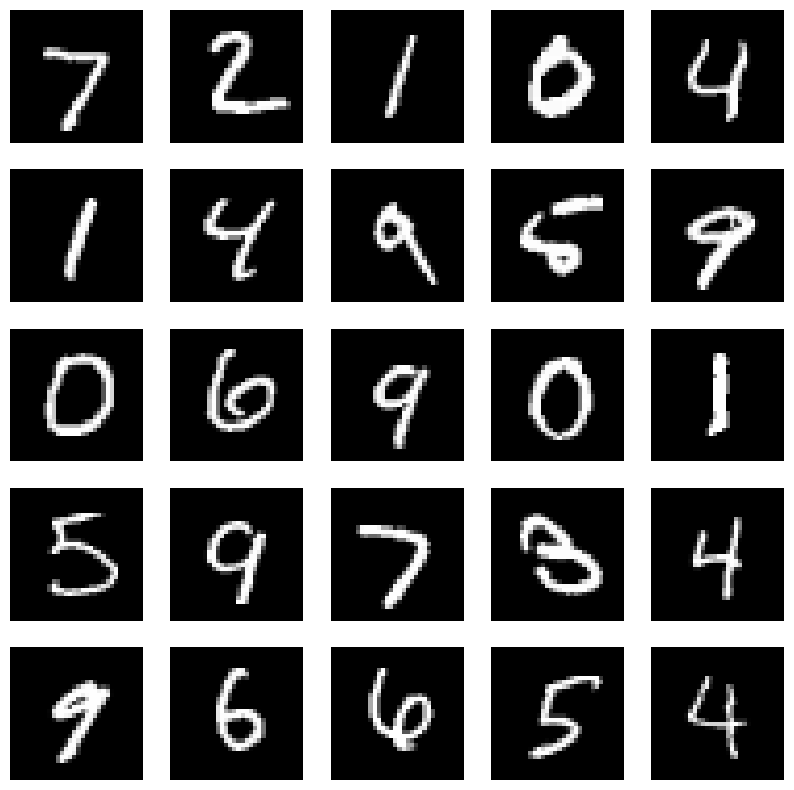

In [4]:
# Concatenate test images from batches
test_images = np.concatenate([batch for batch in iter(test_data)], axis=0)

# Create a plot to display the first 25 test images
plt.figure(figsize=(10, 10))
for index, image in enumerate(test_images[:25]):
    plt.subplot(5, 5, index + 1)
    plt.imshow(image, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')
plt.show()


Moving fwd with fwd process

In [5]:
n_freqs = 9
tmax = 1000
betas = np.linspace(0.0001, 0.02, tmax).astype(np.float32)
alphas = 1 - betas
alphas_bar = np.cumprod(alphas)

In [6]:
def noise_added_image(img, t):
    """Add noise to an image based on a specific timestep 't'."""
    scale_factor = np.sqrt(1 - alphas_bar[t])
    img_mean = np.sqrt(alphas_bar[t]) * img + scale_factor * np.random.normal(size=img.shape)
    normal_dist = tfpd.Normal(loc=img_mean, scale=scale_factor)
    noisy_img = normal_dist.sample(1)
    noisy_img = tf.squeeze(noisy_img, axis=0)
    return noisy_img


In [7]:
# Define initial settings for sampling
sample_idx = 0
selected_timestep = 2
timesteps_list = [1, 2, 5, 10, 20, 50, 100, 500, tmax]


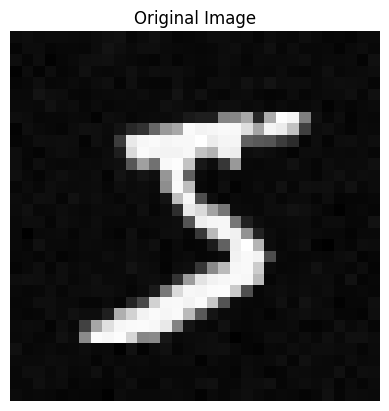

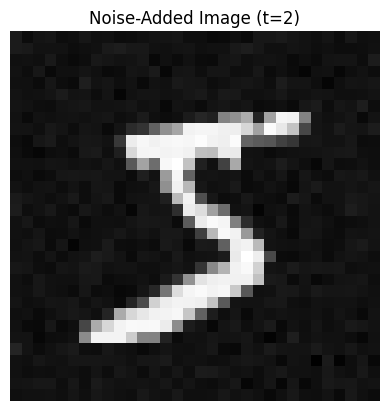

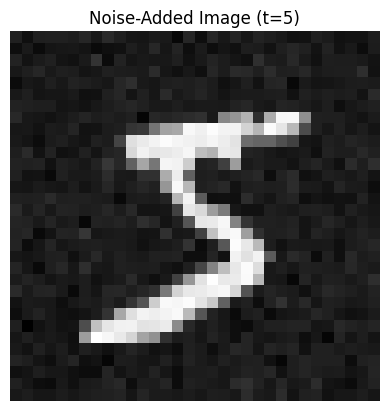

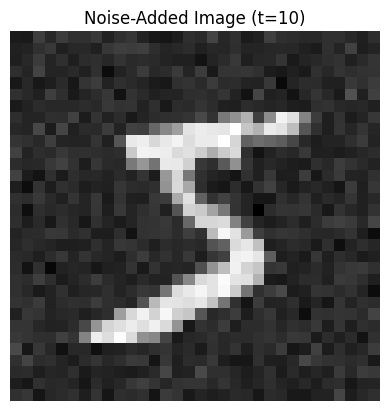

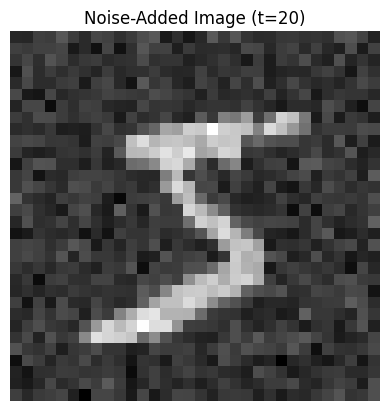

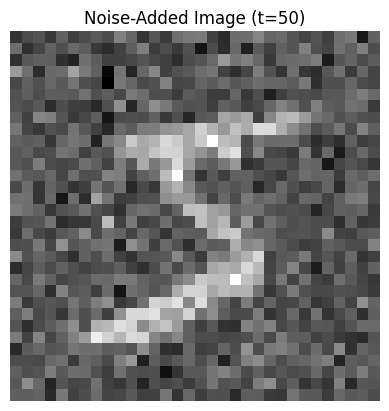

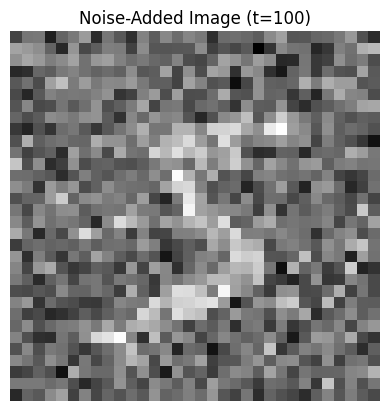

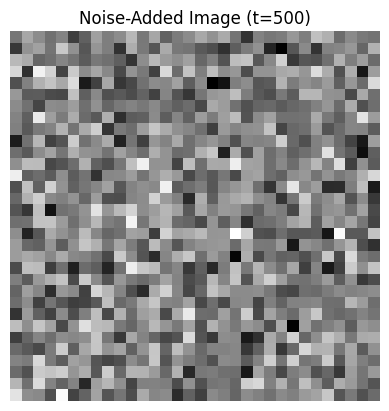

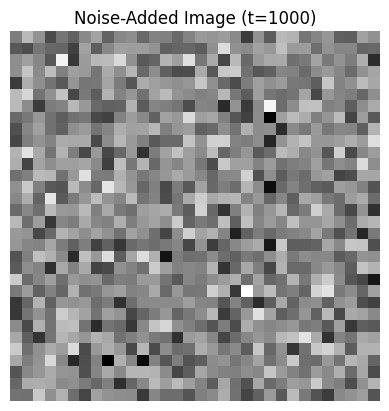

In [8]:
# Process and display images at different noise levels
for timestep in timesteps_list:
    original_image = train_images[sample_idx]
    modified_image = noise_added_image(original_image, timestep - 1)
    if timestep == 1:
        plt.title('Original Image')
        plt.imshow(modified_image, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        plt.title(f'Noise-Added Image (t={timestep})')
        plt.imshow(modified_image, cmap='gray')
        plt.axis('off')
        plt.show()


Positional encoding

In [63]:
def encode_position(input_t, num_frequencies):
    # input_t: b x 1
    # n_freqs: scalar
    # returns b x (2*n_freqs)
    exponents = tf.range(n_freqs, dtype=tf.float32)  # n_freqs vector
    frequencies = tf.pow(2., exponents)  # same
    sines = tf.math.sin(2*np.pi*frequencies*input_t)  # b x n_freqs
    cosines =  tf.math.cos(2*np.pi*frequencies*input_t)  # b x n_freqs
    return tf.concat([sines, cosines], axis=-1)  # b x 2*n_freqs

Diff model

In [64]:
def apply_noise_during_training(image, time_step, random_noise):
    mean_img = np.reshape(np.sqrt(alphas_bar[time_step]), (time_step.shape[0], 1, 1, 1)) * image
    scale_factor = np.reshape(np.sqrt((1 - alphas_bar[time_step])).astype("float32"), (time_step.shape[0], 1, 1, 1))
    noised_image = mean_img + scale_factor * random_noise
    return noised_image


Loss Func

In [65]:
def squared_error(target, predicted):
    return tf.reduce_sum((target - predicted) ** 2)


MODEL

In [66]:
class DiffusionModel(tfk.models.Model):
  def __init__(self, **kwargs):
    super(DiffusionModel, self).__init__(**kwargs)
    self.distrib = tfp.distributions.Normal(loc=0, scale=1)

    # ENCODER
    self.conv2_1 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu2_1 = tfk.layers.ReLU()
    self.conv2_2 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu2_2 = tfk.layers.ReLU()
    self.maxpool2 = tfk.layers.MaxPool2D()

    self.conv3_1 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu3_1 = tfk.layers.ReLU()
    self.conv3_2 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu3_2 = tfk.layers.ReLU()
    self.maxpool3 = tfk.layers.MaxPool2D()

    self.conv4_1 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu4_1 = tfk.layers.ReLU()
    self.conv4_2 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu4_2 = tfk.layers.ReLU()
    self.maxpool4 = tfk.layers.MaxPool2D()

    self.conv5_1 = tfk.layers.Conv2D(512, 3, padding='same')
    self.relu5_1 = tfk.layers.ReLU()
    self.conv5_2 = tfk.layers.Conv2D(512, 3, padding='same')
    self.relu5_2 = tfk.layers.ReLU()

    #DECODER
    self.upconv1 = tfk.layers.Conv2DTranspose(256, 2, strides=2, padding='same')

    self.concat1 = tfk.layers.Concatenate()
    self.conv6_1 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu6_1 = tfk.layers.ReLU()
    self.conv6_2 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu6_2 = tfk.layers.ReLU()

    self.upconv2 = tfk.layers.Conv2DTranspose(256, 2, strides=2, padding='same')

    self.concat2 = tfk.layers.Concatenate()
    self.conv7_1 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu7_1 = tfk.layers.ReLU()
    self.conv7_2 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu7_2 = tfk.layers.ReLU()

    self.upconv3 = tfk.layers.Conv2DTranspose(256, 2, strides=2, padding='same')

    self.concat3 = tfk.layers.Concatenate()
    self.conv8_1 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu8_1 = tfk.layers.ReLU()
    self.conv8_2 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu8_2 = tfk.layers.ReLU()
    self.conv1x1 = tfk.layers.Conv2D(3, 1, padding='same')

  @tf.function
  def call(self, input):
    (x, t) = input
    t = tf.cast(t, dtype='float32')

    # Positional encoding
    pos_enc = tf.map_fn(lambda te: encode_position(te, n_freqs), t)
    pos_features = tf.ones((x.shape[0], x.shape[1], x.shape[2], n_freqs*2)) * pos_enc
    input_with_pos_enc = tf.concat([x, pos_features], axis=-1)

    # Encoder
    x32 = self.relu2_2(self.conv2_2(self.relu2_1(self.conv2_1(input_with_pos_enc))))
    x16 = self.relu3_2(self.conv3_2(self.relu3_1(self.conv3_1(self.maxpool2(x32)))))
    x8 = self.relu4_2(self.conv4_2(self.relu4_1(self.conv4_1(self.maxpool3(x16)))))
    x4 = self.relu5_2(self.conv5_2(self.relu5_1(self.conv5_1(self.maxpool4(x8)))))

    # Decoder
    x8 = self.relu6_2(self.conv6_2(self.relu6_1(self.conv6_1(self.concat1([x8, self.upconv1(x4)])))))
    x16 = self.relu7_2(self.conv7_2(self.relu7_1(self.conv7_1(self.concat2([x16, self.upconv2(x8)])))))
    x32 = self.relu8_2(self.conv8_2(self.relu8_1(self.conv8_1(self.concat3([x32, self.upconv3(x16)])))))
    out = self.conv1x1(x32)

    return out

  @tf.function
  def train_step(self, input):
    ts = np.random.randint(0, tmax, input.shape[0])
    rnd_noise = self.distrib.sample(sample_shape=input.shape)
    diffused_data = apply_noise_during_training(input, ts, rnd_noise)
    with tf.GradientTape() as tape:
      predicted_noise = self.call((diffused_data, ts))
      loss = squared_error(rnd_noise, predicted_noise)
    vars = self.trainable_variables
    grads = tape.gradient(loss, vars)
    self.optimizer.apply_gradients(zip(grads, vars))
    return {
        "squared loss": loss,
    }

In [67]:
model = DiffusionModel()
optimizer = tfk.optimizers.Adam()
model.compile(optimizer=optimizer)


In [68]:
model.fit(train_images, epochs = 10)


Epoch 1/10
1875/1875 [==============================] - 89s 44ms/step - squared loss: 3593.7094
Epoch 2/10
1875/1875 [==============================] - 82s 44ms/step - squared loss: 148624.3963
Epoch 3/10
1875/1875 [==============================] - 80s 42ms/step - squared loss: 7872.8297
Epoch 4/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 4551.0842
Epoch 5/10
1875/1875 [==============================] - 80s 43ms/step - squared loss: 3866.4002
Epoch 6/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 3509.7747
Epoch 7/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 3268.2705
Epoch 8/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 3066.1710
Epoch 9/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 2936.2808
Epoch 10/10
1875/1875 [==============================] - 80s 42ms/step - squared loss: 2832.4236


Sampling

In [69]:
def sample(model, timesteps):
    # Initialize x_t with random noise
    x_t = tf.random.normal(shape=(1, 32, 32, 1), dtype=tf.float32)
    for t in reversed(range(1, timesteps + 1)):
        # Uncomment below to check the shape of x_t at each timestep
        # print(x_t.shape)
        z = tf.random.normal(shape=(1, 32, 32, 1), dtype=tf.float32) if t > 1 else 0
        outer_part = tf.sqrt(1.0 / tf.cast(alphas[t - 1], dtype=tf.float32))

        model_input = (x_t, tf.ones((1, 1), dtype=tf.float32) * t)

        epsilon_theta = model((x_t, tf.ones(1)))

        alpha_bar_t = tf.sqrt(tf.cast(alphas_bar[t - 1], dtype=tf.float32) / tf.cast(alphas[t - 1], dtype=tf.float32))

        inner_part = x_t - alpha_bar_t * epsilon_theta
        x_t = outer_part * inner_part + tf.sqrt(tf.cast(betas[t - 1], dtype=tf.float32)) * z
    return x_t


Sampling Not working

In [70]:
# Sample images from the trained model
num_samples = 10
sampled_images = []
T = 1000  # Define the number of timesteps for the sampling process
for _ in range(num_samples):
    sampled_image = sample(model, T)
    sampled_images.append(sampled_image[0])
sampled_images = np.array(sampled_images)

# Normalize the images to scale them between 0 and 1
sampled_images = (sampled_images + 1) / 2

# Display the sampled images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i, image in enumerate(sampled_images):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()


ValueError: Exception encountered when calling layer 'diffusion_model_9' (type DiffusionModel).

in user code:

    File "<ipython-input-51-5b6ae3a14c36>", line 67, in call  *
        x32 = self.relu2_2(self.conv2_2(self.relu2_1(self.conv2_1(input_with_pos_enc))))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "conv2d_141" is incompatible with the layer: expected axis -1 of input shape to have value 33, but received input with shape (1, 32, 32, 35)


Call arguments received by layer 'diffusion_model_9' (type DiffusionModel):
  • input=('tf.Tensor(shape=(1, 32, 32, 3), dtype=float32)', 'tf.Tensor(shape=(1,), dtype=float32)')

Testingg

In [71]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [72]:
# Importing the MNIST dataset
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values to range between [-1, 1]
x_train = x_train.astype('float32') / 255.0 * 2 - 1
x_test = x_test.astype('float32') / 255.0 * 2 - 1

# Introducing random noise to the training and test data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# Clipping the noisy data to stay within the valid range
x_train_noisy = tf.clip_by_value(x_train_noisy, -1.0, 1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, -1.0, 1.0)


In [73]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define diffusion model parameters
T = 1000
betas = np.linspace(0.0001, 0.02, T)
alphas = 1.0 - betas
alpha_bar = np.cumprod(alphas)

# Define the architecture of the denoising diffusion model
input_shape = (28, 28, 1)
latent_dim = 32
n_freqs = 16  # Assuming n_freqs needs to be defined

# Input layers for the model
inputs = Input(shape=input_shape)
timesteps = Input(shape=(1,))

# Calculate positional encoding for the timesteps
frequencies = [2**i for i in range(n_freqs // 2)]
encoding = Concatenate()([
    tf.math.sin(timesteps * frequency) for frequency in frequencies
] + [
    tf.math.cos(timesteps * frequency) for frequency in frequencies
])
encoding = tf.expand_dims(encoding, axis=1)
encoding = tf.expand_dims(encoding, axis=1)

# Adjust encoding to match input dimensions
encoding = tf.tile(encoding, [1, input_shape[0], input_shape[1], 1])

# Combine the inputs and encoding
x = Concatenate()([inputs, encoding])

# Encoder network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Latent representation
latent = Conv2D(latent_dim, (3, 3), activation='relu', padding='same')(x)

# Decoder network
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(latent)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
outputs = Conv2DTranspose(1, (3, 3), activation='tanh', padding='same')(x)

# Final model definition
model = Model([inputs, timesteps], outputs)

# Loss function for training
def diffusion_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Model compilation and training
model.compile(optimizer=Adam(learning_rate=0.001), loss=diffusion_loss)
model.fit([x_train_noisy, np.random.choice(T, size=x_train.shape[0])], x_train,
          batch_size=128, epochs=10, validation_data=([x_test_noisy, np.random.choice(T, size=x_test.shape[0])], x_test))

# Normalize the training and testing datasets for output
x_train = (x_train + 1) / 2
x_test = (x_test + 1) / 2


Epoch 1/10
469/469 [==============================] - 8s 13ms/step - loss: 0.2971 - val_loss: 0.0175
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 8/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 10/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0127 - val_lo

In [74]:
def sample(model, timesteps):
    x_t = tf.random.normal(shape=(1, 28, 28, 1), dtype=model.inputs[0].dtype)
    for t in reversed(range(1, timesteps + 1)):
        z = tf.random.normal(shape=(1, 28, 28, 1), dtype=model.inputs[0].dtype) if t > 1 else 0
        outer_part = tf.sqrt(1.0 / tf.cast(alphas[t - 1], dtype=model.inputs[0].dtype))
        epsilon_theta=model((x_t, t))
        inner_part = (x_t - ((1-alphas[t])- tf.sqrt((1-alphas_bar[t]))) * epsilon_theta)
        #alpha_bar_t = tf.sqrt(tf.cast(alpha_bar[t - 1], dtype=model.inputs[0].dtype) / tf.cast(alphas[t - 1], dtype=model.inputs[0].dtype))
        #noise = alpha_t * x_t + alpha_bar_t * model([x_t, tf.ones((1, 1), dtype=model.inputs[1].dtype) * t])
        x_t = noise + tf.sqrt(tf.cast(betas[t - 1], dtype=model.inputs[0].dtype)) * z
    return x_t


# Sample images from the trained model
num_samples = 10
sampled_images = []
for _ in range(num_samples):
    sampled_image = sample(model, T)
    sampled_images.append(sampled_image[0])
sampled_images = np.array(sampled_images)

# Reverse scaling of the sampled images
sampled_images = (sampled_images + 1) / 2

# Display the sampled images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i, image in enumerate(sampled_images):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()

InvalidArgumentError: Exception encountered when calling layer 'concatenate_34' (type Concatenate).

{{function_node __wrapped__ConcatV2_N_16_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Can't concatenate scalars (use tf.stack instead) [Op:ConcatV2] name: concat

Call arguments received by layer 'concatenate_34' (type Concatenate):
  • inputs=['tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)', 'tf.Tensor(shape=(), dtype=float32)']